# Core API

> Scikit-learn compatible transforms for spectroscopic data preprocessing.

In [ ]:
#| default_exp core

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
from fastcore.all import *
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.signal import savgol_filter
from typing import Callable

Let's load some data to get started using the soilspecdata package.

In [ ]:
#| eval: false
from soilspecdata.datasets.ossl import get_ossl
from sklearn.pipeline import Pipeline
from soilspectfm.visualization import plot_spectra
from matplotlib import pyplot as plt
from soilspectfm.visualization import plot_spectra_comparison
from soilspectfm.utils import load_toy_mir

In [ ]:
#| eval: false
X, ws = load_toy_mir()

## Baseline corrections

In [ ]:
#| exports
class SNV(BaseEstimator, TransformerMixin):
    """Standard Normal Variate transformation with flexible centering and scaling.
    
    Common centering functions:
    - np.mean: Standard choice, sensitive to outliers
    - np.median: Robust to outliers, slower computation
    - np.min: Ensures positive values, sensitive to noise
    - lambda x, **kw: 0: No centering, preserves absolute values
    
    Common scaling functions:
    - np.std: Standard choice, assumes normal distribution
    - lambda x, **kw: np.sqrt(np.mean(x**2, **kw)): RMS, good for baseline variations
    - scipy.stats.iqr: Robust to outliers, ignores extreme peaks
    - lambda x, **kw: np.max(x, **kw) - np.min(x, **kw): Preserves relative peaks
    - lambda x, **kw: np.median(np.abs(x - np.median(x, **kw)), **kw): Most robust, slower
    """
    def __init__(self, 
                 center_func: Callable=np.mean, # Function to center the data
                 scale_func: Callable=np.std, # Function to scale the data
                 eps: float=1e-10 # Small value to avoid division by zero
                 ):
        store_attr()
    def fit(self, X, y=None): return self
    def transform(self, X):
        center = self.center_func(X, axis=1, keepdims=True)
        scale = self.scale_func(X - center, axis=1, keepdims=True) + self.eps
        return (X - center) / scale

In [ ]:
#|eval: false
X_tfm = SNV().fit_transform(X)

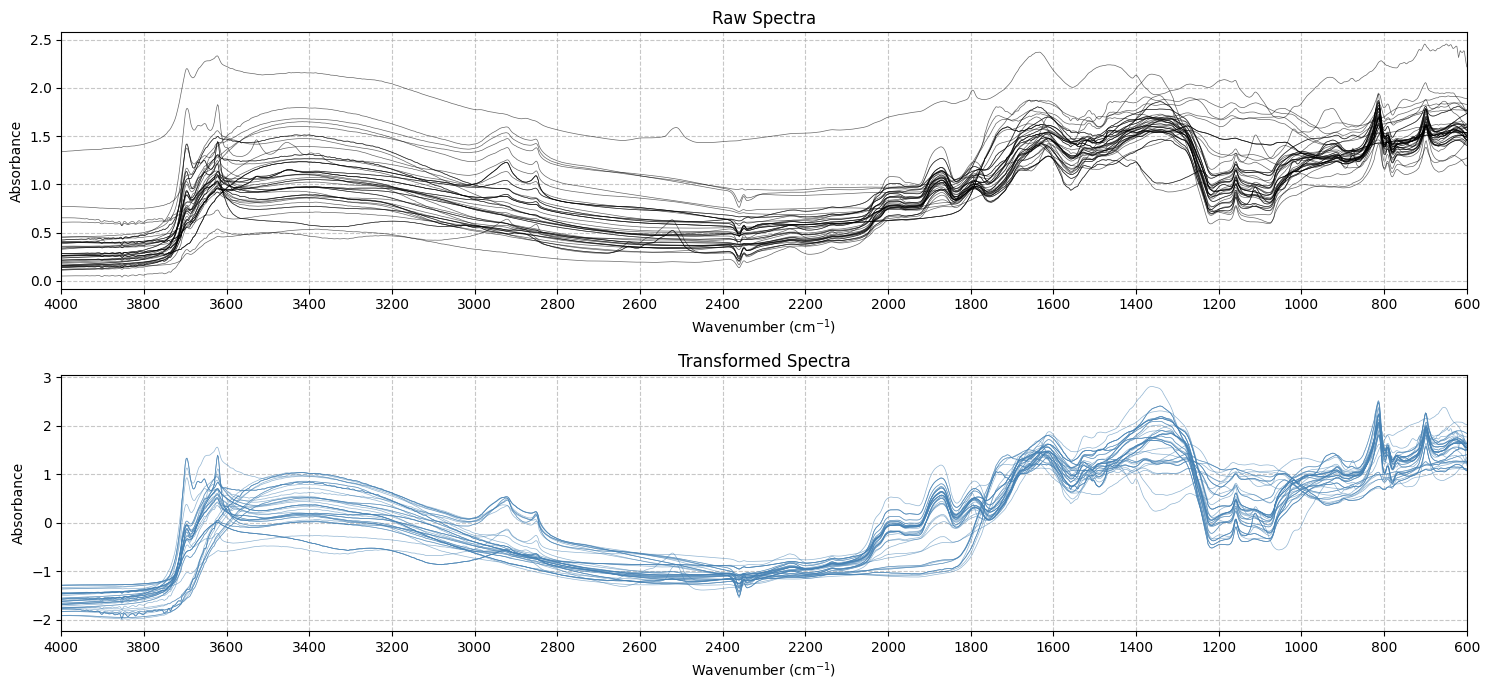

In [ ]:
#| eval: false
plot_spectra_comparison(
    X,
    SNV().fit_transform(X),
    ws,
    raw_title='Raw Spectra',
    transformed_title='Transformed Spectra'
);

In [ ]:
#| exports
class MSC(BaseEstimator, TransformerMixin):
    "Multiplicative Scatter Correction with fastai-style implementation"
    def __init__(self, 
                 reference_method: Union[str, np.ndarray] = 'mean', # Method to compute reference spectrum ('mean'/'median') or custom reference spectrum
                 n_jobs: Optional[int] = None # Number of parallel jobs to run. None means using all processors
                 ):
        store_attr()
        self.reference_ = None
        
    def _compute_reference(self, x: np.ndarray):
        "Compute reference spectrum from array using specified method"
        if isinstance(self.reference_method, str):
            assert self.reference_method in ['mean', 'median'], "reference_method must be 'mean' or 'median'"
            return np.mean(x, axis=0) if self.reference_method == 'mean' else np.median(x, axis=0)
        return np.array(self.reference_method)
    
    def fit(self, X: np.ndarray, y=None):
        "Compute the reference spectrum"
        self.reference_ = self._compute_reference(X)
        return self
    
    def _transform_single(self, x: np.ndarray):
        "Transform a single spectrum"
        coef = np.polyfit(self.reference_, x, deg=1)
        return (x - coef[1]) / coef[0]
    
    def transform(self, X: np.ndarray):
        "Apply MSC to the spectra"
        if self.reference_ is None: raise ValueError("MSC not fitted. Call 'fit' first.")
        return np.array(parallel(self._transform_single, X, n_workers=self.n_jobs))

In [ ]:
#| eval: false
X_tfm = MSC(reference_method='median').fit_transform(X)

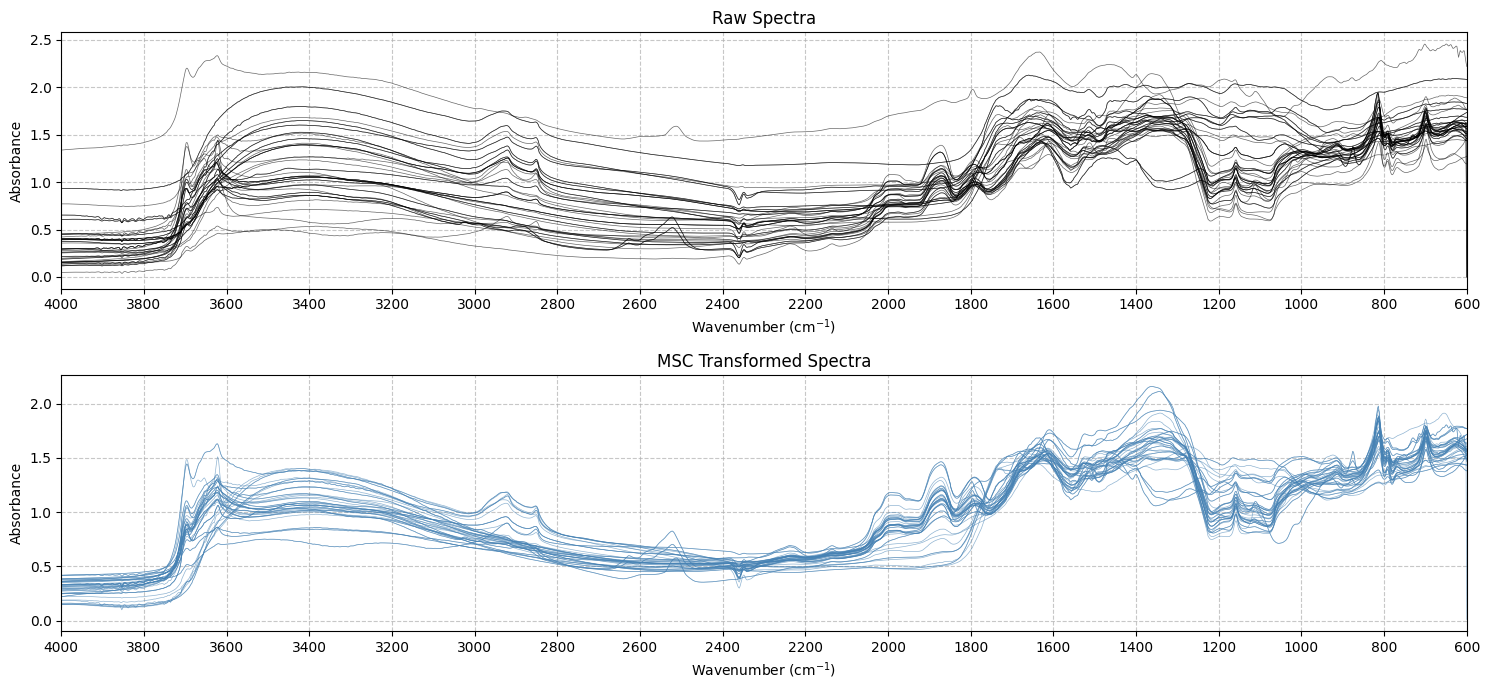

In [ ]:
#| eval: false
plot_spectra_comparison(
    X,
    MSC().fit_transform(X),
    ws,
    raw_title='Raw Spectra',
    transformed_title='MSC Transformed Spectra'
);

References:
- https://eigenvector.com/wp-content/uploads/2020/01/RobustFittingtoBasisFunctionsIII.pdf
- https://nirpyresearch.com/two-methods-baseline-correction-spectral-data/
- https://diposit.ub.edu/dspace/bitstream/2445/188026/1/2014_IEEE_Adaptive_MarcoS_postprint.pdf

In [ ]:
class ALS(BaseEstimator, TransformerMixin):
    "Asymmetric least squares detrending"
    pass


## Derivatives

In [ ]:
#| exports
class TakeDerivative(BaseEstimator, TransformerMixin):
    "Creates scikit-learn derivation + savitsky-golay smoothing custom transformer"
    def __init__(self, 
                 window_length=11, # Window length for the savgol filter
                 polyorder=1, # Polynomial order for the savgol filter
                 deriv=1 # Derivation degree
                 ):
        self.window_length = window_length
        self.polyorder = polyorder
        self.deriv = deriv

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return savgol_filter(X, self.window_length, self.polyorder, self.deriv)

How to use the TakeDerivative transformer in combination with the SNV transformer?

In [ ]:
#| eval: false
pipe = Pipeline([('snv', SNV()), 
                 ('deriv', TakeDerivative(deriv=1))
                 ])

X_tfm = pipe.fit_transform(X)

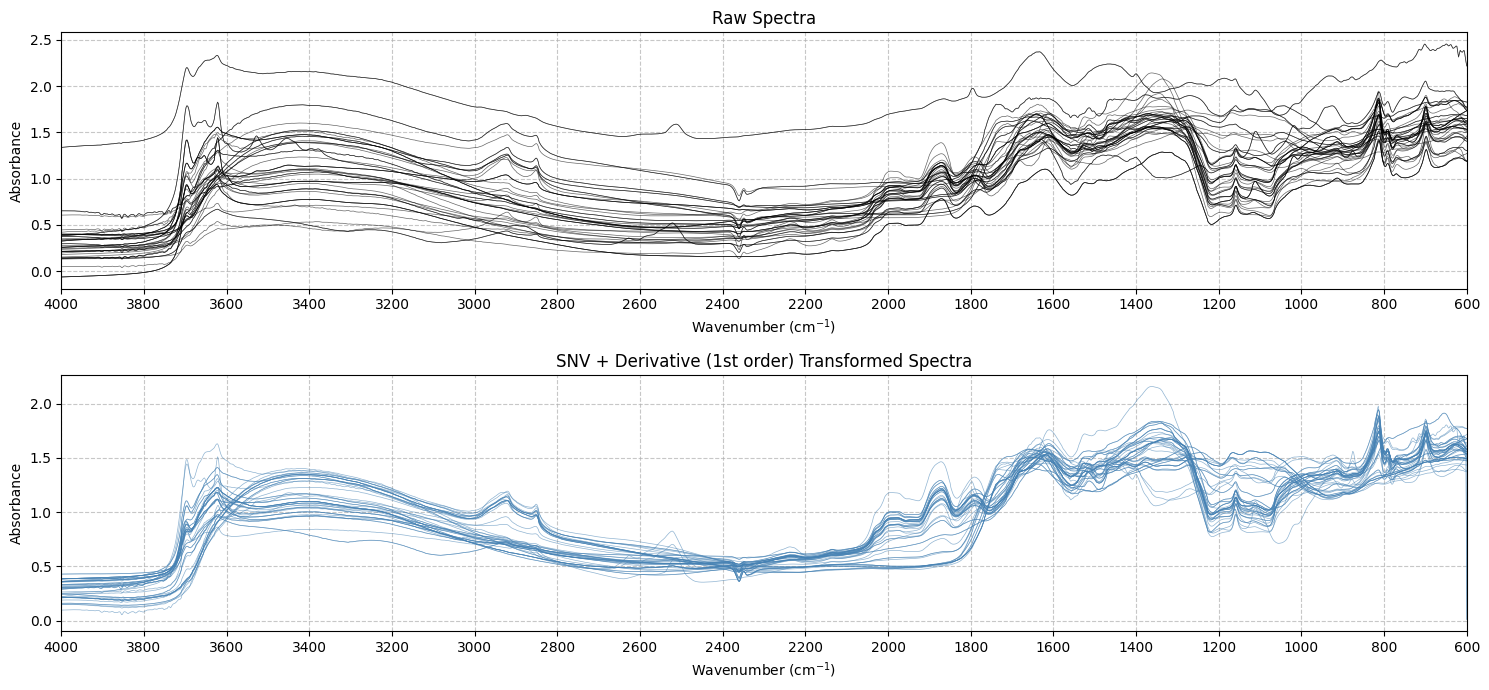

In [ ]:
#| eval: false
plot_spectra_comparison(
    X,
    MSC().fit_transform(X),
    ws,
    raw_title='Raw Spectra',
    transformed_title='SNV + Derivative (1st order) Transformed Spectra'
);


## Other Transformations

In [ ]:
#| exports
class ToAbsorbance(BaseEstimator, TransformerMixin):
    "Creates scikit-learn transformer to transform reflectance to absorbance"
    def __init__(self, 
                 eps: float=1e-5 # Small value to avoid log(0)
                 ): self.eps = eps
    def fit(self, X, y=None): return self
    def transform(self, X, y=None): return -np.log10(np.clip(X, self.eps, 1))